In [135]:
import cv2                 # handling images
import numpy as np         # dealing with arrays
import os                  # handling directories
from random import shuffle 
import tflearn 
from tqdm import tqdm      # a nice percentage bar for tasks.

#fun fact: tqdm means "progress" in Arabic (taqadum, تقدّم)

In [136]:
TRAIN_DIR ='train/' #your directory
TEST_DIR = 'test/'  #your directory
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, 'convnn-basic')

In [45]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #[1,0] =
  
    if word_label == 'cat': return [1,0]
  
    elif word_label == 'dog': return [0,1]

In [46]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data


In [47]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [54]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 25000/25000 [00:23<00:00, 1047.79it/s]


In [61]:
import tensorflow as tf
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')




In [62]:
train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [63]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)





Training Step: 1148  | total loss: 0.46072 | time: 47.931s
| Adam | epoch: 003 | loss: 0.46072 - acc: 0.8000 -- iter: 24448/24500
Training Step: 1149  | total loss: 0.45707 | time: 49.102s
| Adam | epoch: 003 | loss: 0.45707 - acc: 0.8028 | val_loss: 0.51578 - val_acc: 0.7680 -- iter: 24500/24500
--


100%|██████████| 12500/12500 [00:20<00:00, 596.85it/s]


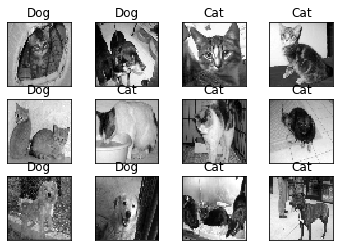

In [65]:
import matplotlib.pyplot as plt

# if you need to create the data:
#test_data = process_test_data()
# if you already have some saved:
test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

[0.11061358 0.8893864 ]
DOG


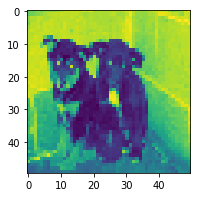

In [134]:
d = test_data[44]
img_data, img_num = d

data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
prediction = model.predict([data])[0]


print(prediction)
if prediction[0]> 0.5 :
    print("CAT")
    
else:
    print("DOG")

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img_data) #cmap="gray")


#print(f"cat: {prediction[0]}, dog: {prediction[1]}")

